In [1]:
import numpy as np
import stars
import matplotlib.pyplot as plt

**Global parameters**

In [2]:
p = 100 # Number of variables
n = 400 # Number of samples

# Fix random seed
np.random.seed(42)

### Generate data

**Using sempler**

In [20]:
import sempler

W = sempler.dag_avg_deg(p, 3, 0.1, 0.2)
sem = sempler.LGANM(W, (1,2))
true_cov = sem.sample(population=True).covariance
true_precision = np.linalg.inv(sem.sample(population=True).covariance)
true_precision -= np.diag(np.diag(true_precision))
X = sem.sample(n)

**Or as described in the StARS paper (neighbourhood graph, https://arxiv.org/pdf/1006.3316.pdf, page 10)**

In [22]:
def neighbourhood_graph(p, max_nonzero=2, rho=0.245):
    Y = np.random.uniform(size=(p,2))
    prob = np.zeros((p,p))
    precision = np.zeros((p,p))
    for i in range(p):
        for j in range(p):
            if i!=j:
                dist = (Y[i,:] - Y[j,:]) @ (Y[i,:] - Y[j,:]).T
                prob[i,j] = 1 / np.sqrt(2*np.pi) * np.exp(-16 * dist)
    for i in range(p):
        indices = np.argsort(prob[i,:])[-max_nonzero:]
        precision[i,indices] = rho
        precision[indices,i] = rho
    precision[range(p), range(p)] = 1
    return precision

true_precision = neighbourhood_graph(p)
true_covariance = np.linalg.inv(true_precision)
X = np.random.multivariate_normal(np.zeros(p), true_covariance, size=n)

### Execution

In [23]:
# Run StARS and then fit GLASSO over all data

# Set subsample size as in the paper
N = int(n / np.floor(10 * np.sqrt(n)))
print("Number of subsamples", N)

# Run StARS to select optimal regularizer
opt, inst = stars.fit_w_glasso(X, 0.05, N, start = 5, step = 0.5, tol=1e-7, max_iter=100, debug=True)
print("Optimal 1/lambda:", opt)

# Fit GLASSO over all samples
estimates, precisions = stars.glasso(stars.subsample(X, 1), opt, return_precisions=True)

Number of subsamples 2
JUMP  0 : f( 5.5 )= 0.011313131313131313  - delta:  0.038686868686868686
JUMP  1 : f( 6.0 )= 0.015252525252525252  - delta:  0.03474747474747475
JUMP  2 : f( 6.5 )= 0.022727272727272728  - delta:  0.027272727272727275
JUMP  3 : f( 7.0 )= 0.03383838383838384  - delta:  0.01616161616161616
   4 : f( 7.5 )= 0.044343434343434344 > 0.05
   5 : f( 7.25 )= 0.044343434343434344 > 0.05
JUMP  6 : f( 7.125 )= 0.044343434343434344  - delta:  0.005656565656565658
   7 : f( 7.25 )= 0.04787878787878788 > 0.05
JUMP  8 : f( 7.1875 )= 0.04787878787878788  - delta:  0.002121212121212121
   9 : f( 7.25 )= 0.049595959595959596 > 0.05
   10 : f( 7.21875 )= 0.049595959595959596 > 0.05
JUMP  11 : f( 7.203125 )= 0.049595959595959596  - delta:  0.00040404040404040664
   12 : f( 7.21875 )= 0.0498989898989899 > 0.05
   13 : f( 7.2109375 )= 0.0498989898989899 > 0.05
JUMP  14 : f( 7.20703125 )= 0.0498989898989899  - delta:  0.00010101010101010166
   15 : f( 7.2109375 )= 0.0498989898989899 > 0

### Analyisis


Precision 0.5726872246696035 Recall 0.9923664122137404


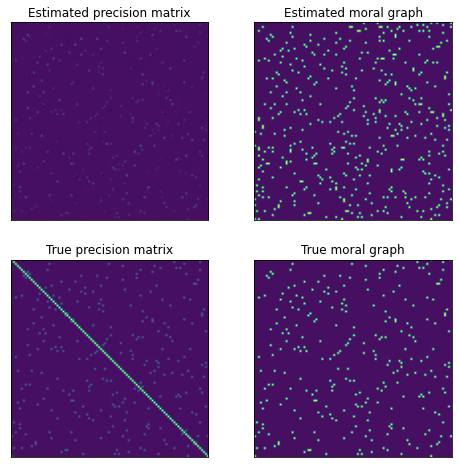

In [28]:
# Analyisis: Precision / recall
moral = (abs(precisions[0, :, :]) > 1e-4).astype(int)
true_moral = (abs(true_precision - np.eye(p)) > 1e-4).astype(int)

true_positives = np.sum(true_moral) - np.sum((true_moral - moral) == 1)
recall = true_positives / np.sum(true_moral)
precision = true_positives / np.sum(moral)
print("\nPrecision", precision, "Recall", recall)

# Plot results
vmin = min([np.min(precisions[0, :, :]), np.min(true_precision)])
vmax = max([np.max(precisions[0, :, :]), np.max(true_precision)])

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.title("Estimated precision matrix")
plt.imshow(precisions[0, :, :], vmin=vmin, vmax=vmax)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplot(222)
plt.title("Estimated moral graph")
plt.imshow(moral, vmin=vmin, vmax=vmax)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplot(223)
plt.title("True precision matrix")
plt.imshow(true_precision, vmin=vmin, vmax=vmax)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplot(224)
plt.title("True moral graph")
plt.imshow(true_moral, vmin=vmin, vmax = vmax)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.show(block=False)

Text(0.5, 1.0, 'Precision & recall as a function of the precision matrix cutoff')

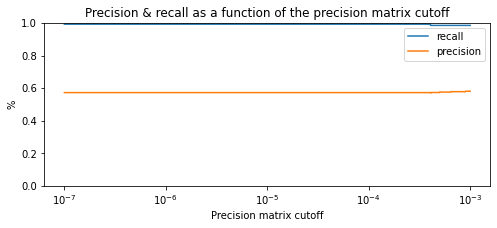

In [29]:
# Evaluate effect of precision tolerance parameter
coefs = (-7,-3)
tols = 10.0**np.linspace(coefs[0], coefs[1],20000)
scores = np.zeros((len(tols), 2))
for i, tol in enumerate(tols):
    moral = (abs(precisions[0, :, :]) > tol).astype(int)
    true_positives = np.sum(true_moral) - np.sum((true_moral - moral) == 1)
    scores[i,0] = true_positives / np.sum(true_moral)
    scores[i,1] = true_positives / np.sum(moral)
    
plt.figure(figsize=(8,3))
plt.plot(np.log10(tols), scores[:,0], label="recall")
plt.plot(np.log10(tols), scores[:,1], label="precision")
ax = plt.gca()
ax.set_xticks(np.arange(coefs[0], coefs[1]+1))
labels = ["$10^{%d}$" % c for c in np.arange(coefs[0], coefs[1]+1)]
ax.set_xticklabels(labels)
plt.legend()
plt.ylim([0,1])
plt.ylabel("%")
plt.xlabel("Precision matrix cutoff")
plt.title("Precision & recall as a function of the precision matrix cutoff")